In [ ]:
# Matteo's version of the plotting
reload(do)
dt=1e-2
import matplotlib.animation as animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
line, = ax.plot(system.grid, do.eval_one_body_density(system, nparticles, C0).real)
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
ani = animation.FuncAnimation(fig, do.animation, fargs=(line, system, dt, t_max, C0, omega, epsilon0, nparticles, integrator), interval=200, blit=True, save_count=1000)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
%reset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do2
from importlib import reload
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem
%load_ext autoreload
%autoreload 2

In [10]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

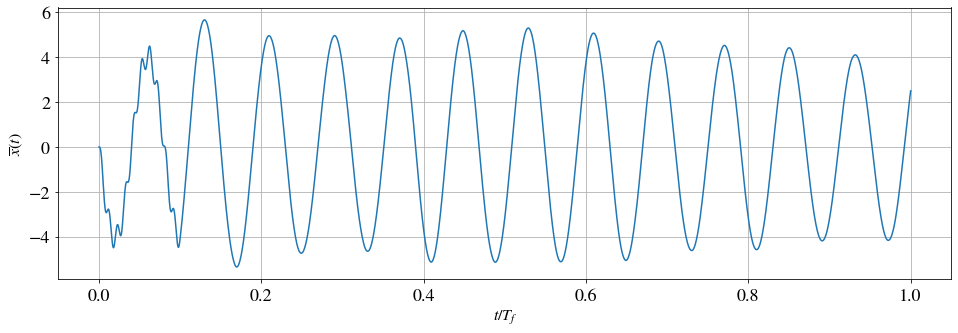

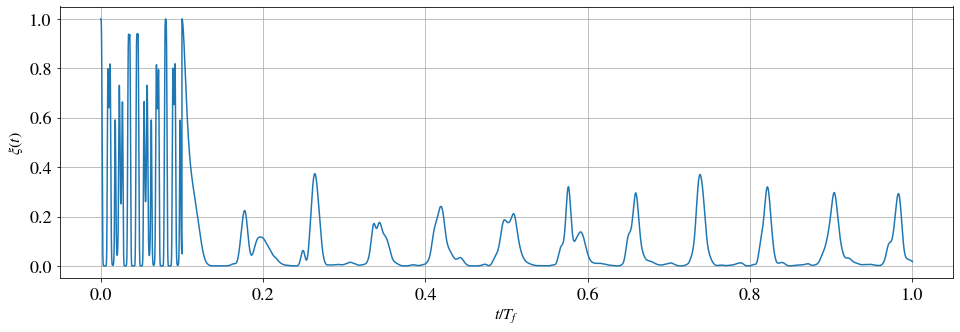

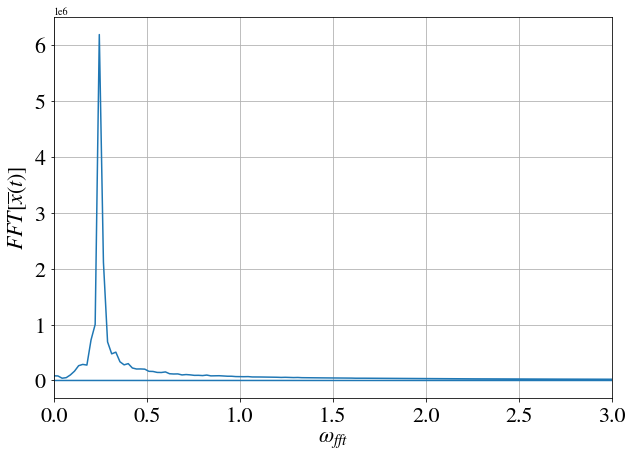

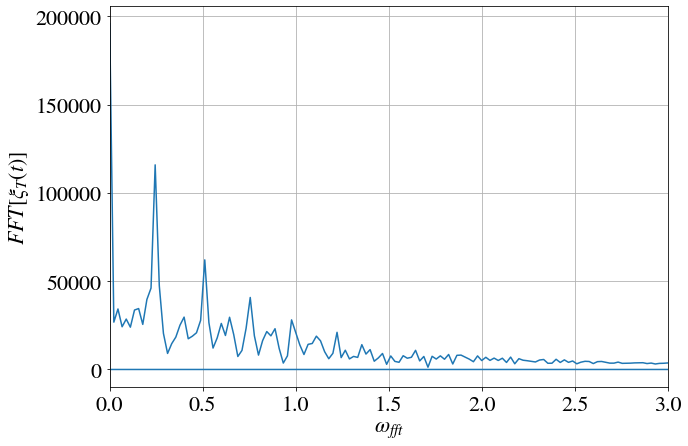

In [11]:
Omega = 0.25
omega = 8*Omega
T_on = 10*np.pi
T_tot = 100*np.pi
ghf = do2.GHF(Omega=Omega, omega=omega)
C2, time1, dipole1, overlap1, xFFT1, xfreqFFT1, overlapFFT1, overlapfreqFFT1 = ghf.fourier_analysis(tolerance=1e-6, max_iter=100, t_laser_ON=T_on, t_max=T_tot, dt=1e-4)
ghf.plot_fourier_analysis(time1, dipole1, overlap1, xFFT1, xfreqFFT1, overlapFFT1, overlapfreqFFT1, save_dipole=True, save_overlap=True, save_fft_x=False, save_fft_overlap=False)

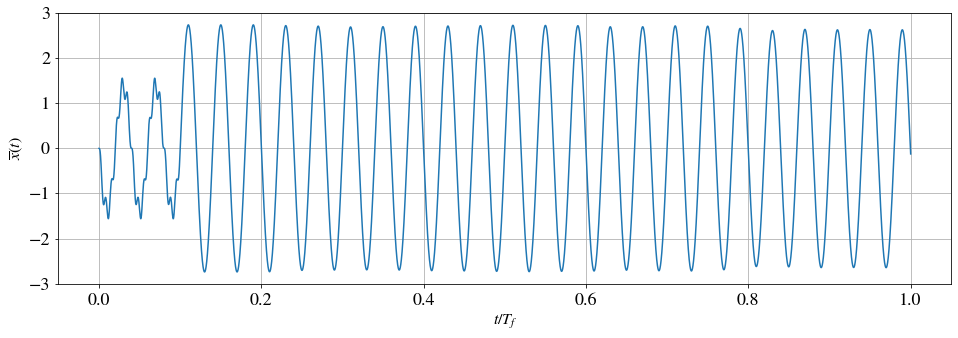

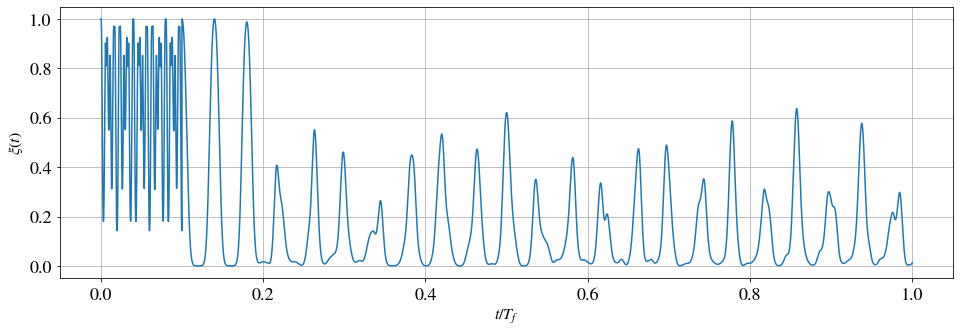

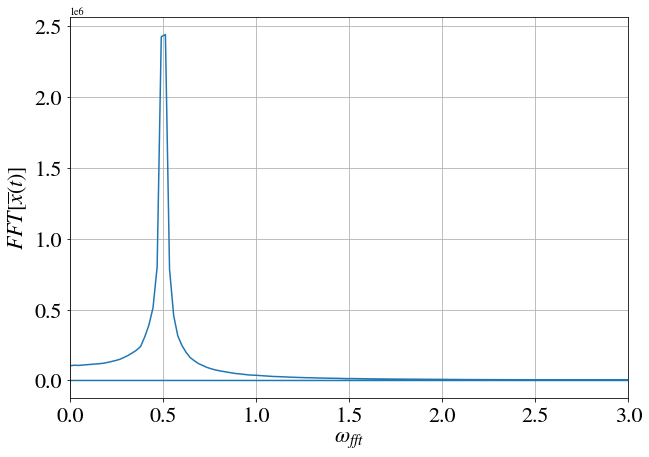

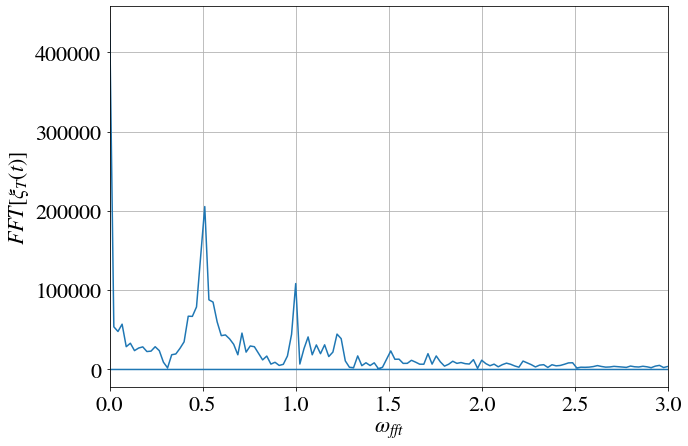

In [12]:
Omega = 0.5
omega = 3.0
T_on = 10*np.pi
T_tot = 100*np.pi
ghf = do2.GHF(Omega=Omega, omega=omega)
C2, time2, dipole2, overlap2, xFFT2, xfreqFFT2, overlapFFT2, overlapfreqFFT2 = ghf.fourier_analysis(tolerance=1e-6, max_iter=100, t_laser_ON=T_on, t_max=T_tot, dt=1e-4)
ghf.plot_fourier_analysis(time2, dipole2, overlap2, xFFT2, xfreqFFT2, overlapFFT2, overlapfreqFFT2, save_dipole=False, save_overlap=False, save_fft_x=False, save_fft_overlap=False)

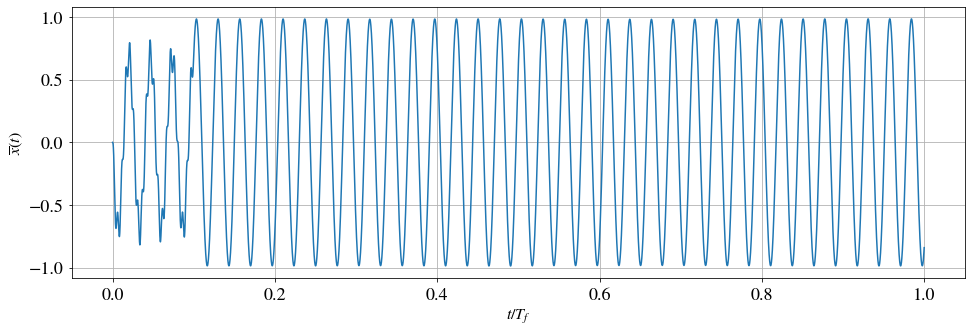

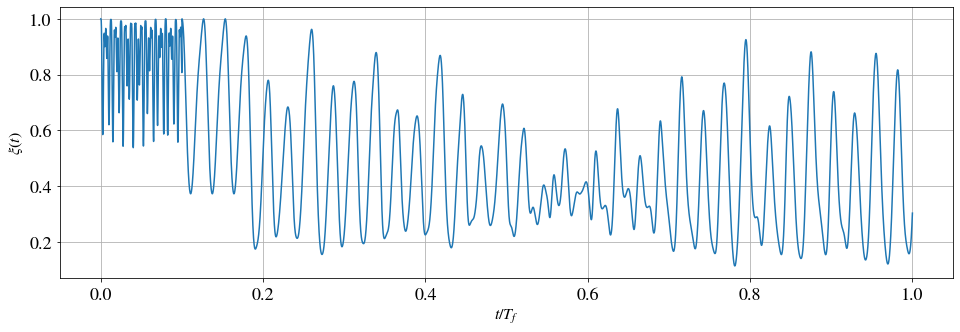

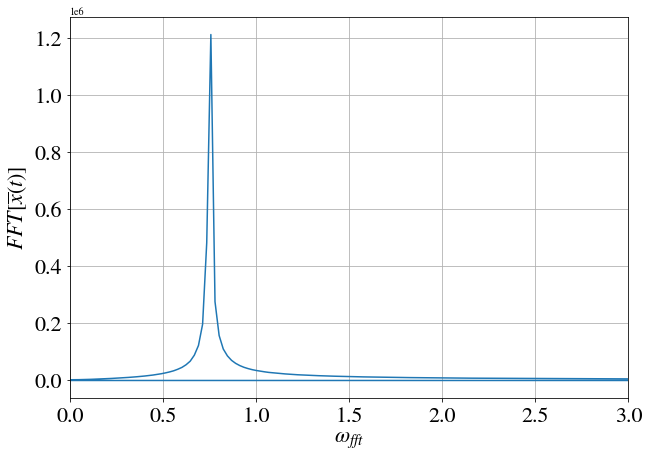

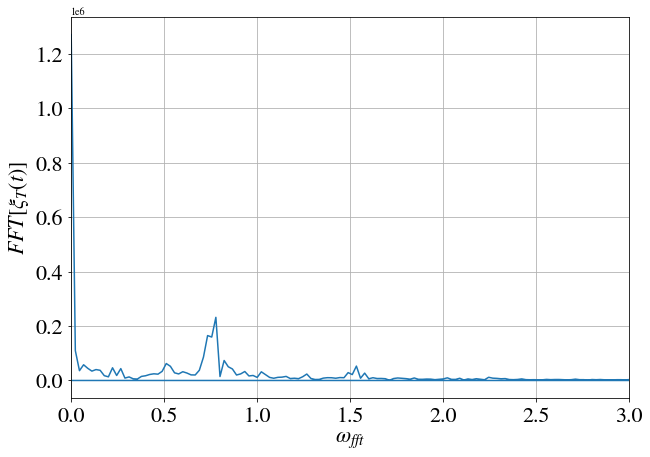

In [16]:
Omega = 0.75
omega = 4.0
T_on = 10*np.pi
T_tot = 100*np.pi
ghf = do2.GHF(Omega=Omega, omega=omega)
C2, time3, dipole3, overlap3, xFFT3, xfreqFFT3, overlapFFT3, overlapfreqFFT3 = ghf.fourier_analysis(tolerance=1e-6, max_iter=100, t_laser_ON=T_on, t_max=T_tot, dt=1e-4)
ghf.plot_fourier_analysis(time3, dipole3, overlap3, xFFT3, xfreqFFT3, overlapFFT3, overlapfreqFFT3, save_dipole=False, save_overlap=False, save_fft_x=False, save_fft_overlap=False)

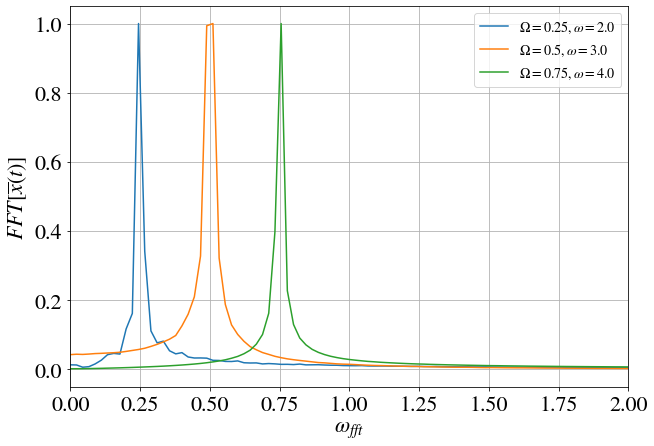

In [19]:
ghf.plot_fft_dipole_comparison(xfreqFFT1, xfreqFFT2, xfreqFFT3, xFFT1, xFFT2, xFFT3, save_fig=False)

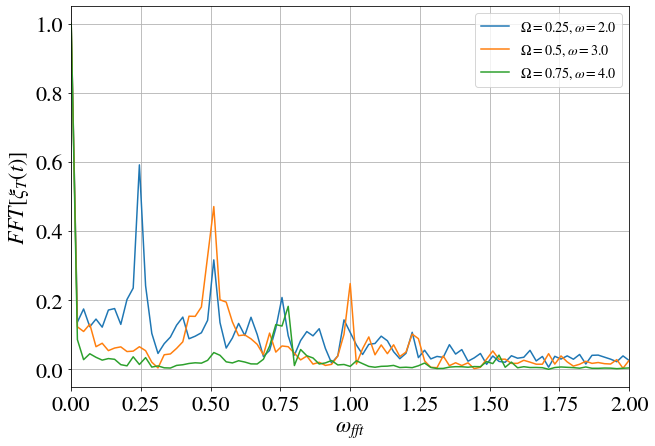

In [20]:
ghf.plot_fft_overlap_comparison(overlapfreqFFT1, overlapfreqFFT2, overlapfreqFFT3, overlapFFT1, overlapFFT2, overlapFFT3, save_fig=False)